In [1]:
%matplotlib inline
from desc.equilibrium import EquilibriaFamily
from desc.plotting import plot_surfaces,plot_section # used to visualize the DESC results
from desc.objectives import MagneticWell
import numpy as np

DESC version 0.4.13+561.g7a8a04c.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 11.54 GB available memory


In [2]:
# get the final equilibriums from DShape and Heliotron
eq_dshape = EquilibriaFamily.load(load_from='./examples/DESC/DSHAPE_output.h5')[-1]
eq_heliotron = EquilibriaFamily.load(load_from='./examples/DESC/HELIOTRON_output.h5')[-1]

(<Figure size 1152x960 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0efc1df130>,
       dtype=object))

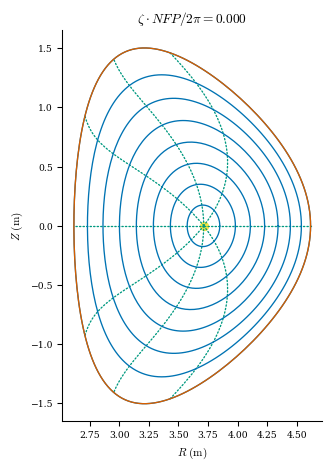

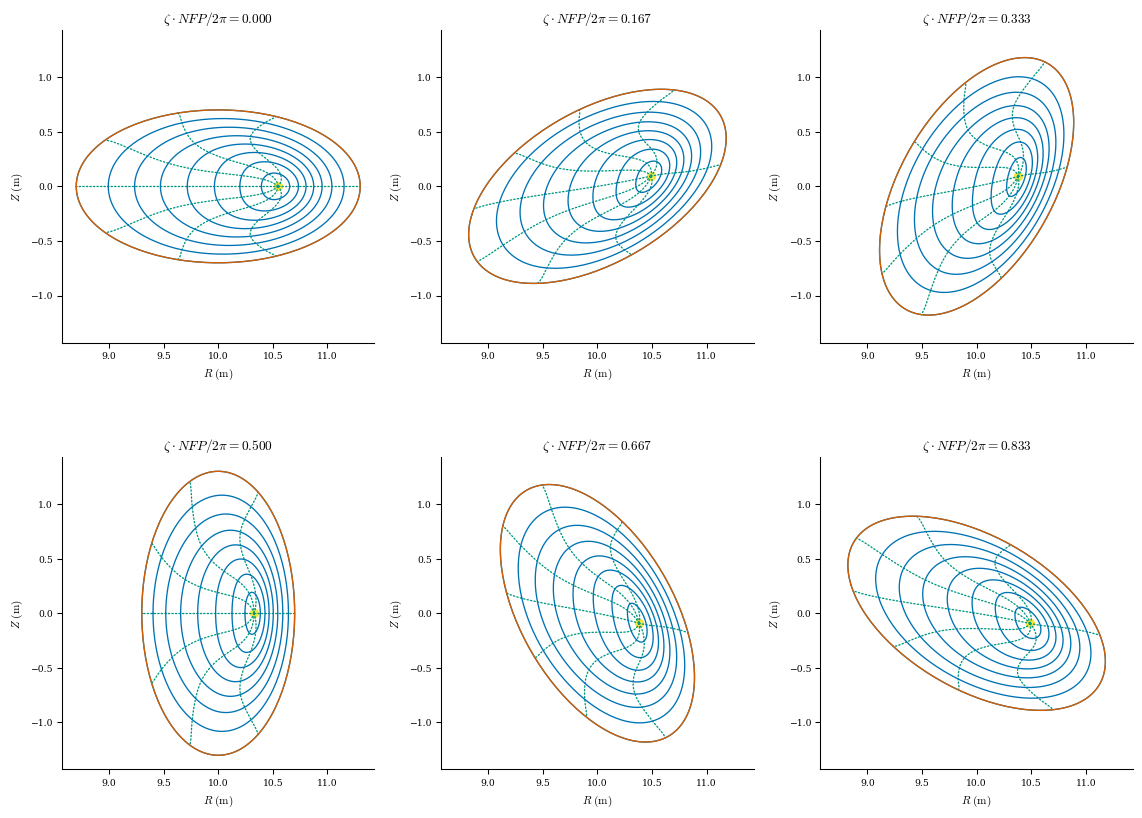

In [3]:
# just to make sure equilibrium were solved correctly on my computer
plot_surfaces(eq_dshape)
plot_surfaces(eq_heliotron)

In [4]:
magwell_dshape = MagneticWell(eq_dshape)
magwell_heliotron = MagneticWell(eq_heliotron)

# This is great, it compiles no errors. But I don't know what flux surface it uses.
# An equilibrium has a bunch of flux surfaces (like the images above). I want to find the magnetic well
# parameter for each of these flux surfaces.
w = magwell_dshape.compute(eq_dshape.R_lmn, eq_dshape.Z_lmn, eq_dshape.L_lmn, eq_dshape.p_l, eq_dshape.i_l, eq_dshape.Psi)
print("w_dshape    " + str(w))
w = magwell_heliotron.compute(eq_heliotron.R_lmn, eq_heliotron.Z_lmn, eq_heliotron.L_lmn, eq_heliotron.p_l, eq_heliotron.i_l, eq_heliotron.Psi)
print("w_heliotron " + str(w))

Precomputing transforms
Precomputing transforms
w_dshape    [-0.09935763]
w_heliotron [-0.86668705]


In [5]:
# I want to compute W for surfaces of constant rho since they are toroidal flux surfaces.
# I can obtain these surfaces with the get_surface_at(rho, theta, zeta) function of the _Configurable super class.
# What I want to use from them is their R_lmn and Z_lmn attributes. I don't think these flux surfaces have
# pressure (p_l), i_l, attributes since these would be something determined by the overall equilibrium, not a
# particular flux surface of constant rho.
# However, the following code throws an error. Does it not make sense to mix R_lmn/Z_lmn of a flux surface with the
# L_lmn of the equilibrium object?

for rho in np.linspace(0.1, 0.9, 8):
    s = eq_dshape.get_surface_at(rho=rho)
    w = magwell_dshape.compute(s.R_lmn, s.Z_lmn, eq_dshape.L_lmn, eq_dshape.p_l, eq_dshape.i_l, eq_dshape.Psi)    
    print("w_dshape    at rho = " + str(rho) + " is " + str(w))

    s = eq_heliotron.get_surface_at(rho=rho)
    w = magwell_heliotron.compute(s.R_lmn, s.Z_lmn, eq_heliotron.L_lmn, eq_heliotron.p_l, eq_heliotron.i_l, eq_heliotron.Psi)
    print("w_heliotron at rho = " + str(rho) + " is " + str(w))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/kaya/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_24658/2309335971.py", line 11, in <cell line: 9>
    w = magwell_dshape.compute(s.R_lmn, s.Z_lmn, eq_dshape.L_lmn, eq_dshape.p_l, eq_dshape.i_l, eq_dshape.Psi)
  File "/home/kaya/.local/lib/python3.8/site-packages/jax/_src/traceback_util.py", line 162, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
  File "/home/kaya/.local/lib/python3.8/site-packages/jax/_src/api.py", line 416, in cache_miss
    out_flat = xla.xla_call(
  File "/home/kaya/.local/lib/python3.8/site-packages/jax/core.py", line 1632, in bind
    return call_bind(self, fun, *args, **params)
  File "/home/kaya/.local/lib/python3.8/site-packages/jax/core.py", line 1623, in call_bind
    outs = primitive.process(top_trace, fun, tracers, params)
  File "/home/kaya/.local/lib/python3.8/s